Potential energy surface for twisting of ethene
===============================================

In [1]:
from pymolpro import Project, all_completed, no_errors
import numpy

In [2]:
root = 'dihedral_scan'
projects = []
import os

if not os.path.isdir(root): os.mkdir(root)
grid = numpy.linspace(0, 90, 18, endpoint=False)
for i, D in enumerate(grid):
    p = Project(f'd{i}', location=root)
    projects.append(p)
    p.write_input(
        f"""geometry={{
        H1
        C1 H1 rch
        C2 C1 rcc H1 A
        H2 C2 rch C1 A H1 D
        H3 C2 rch C1 A H2 180
        H4 C1 rch C2 A H1 180}}
    rch = 2.05; rcc = 2.65; A = 121.5; D ={D}+.01;
    basis = cc-pVTZ
    rhf
    set, mcocc=[3,2,2,2], mcclosed=[3,1,1,2], mcsym=1
    casscf,so_sci
    {{optg; inactive, D}}
    set,mcsym=[1,4]
    casscf,so_sci
    {{mrci; wf, sym=1;}}
    {{mrci; wf, sym=4;}}
    put,xml""")

In [3]:
from multiprocessing.dummy import Pool
from operator import methodcaller

with Pool(processes=8) as pool:
    pool.map(methodcaller('run', backend='local', wait=True),
             projects, 1)
assert all_completed(projects) and no_errors(projects)

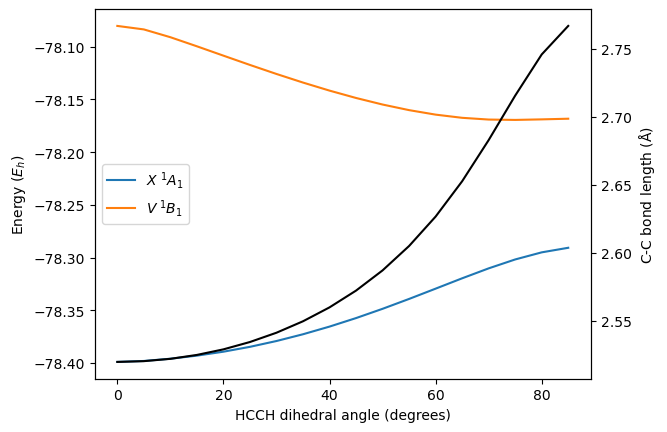

In [4]:
import matplotlib.pyplot as plt

e1 = [p.energy(command='MRCI', stateSymmetry='1') for p in projects]
e2 = [p.energy(command='MRCI', stateSymmetry='4') for p in projects]
cc = [p.variable('RCC') for p in projects]
fig, ax = plt.subplots()
ax.plot(grid, e1, grid, e2)
ax.legend([r'$X\;{}^1A_1$', r'$V\;{}^1B_1$'], loc='center left')
plt.xlabel('HCCH dihedral angle (degrees)')
ax.set_ylabel(r'Energy $(E_h)$')
ax2 = ax.twinx()
ax2.plot(grid, cc, color="black")
ax2.set_ylabel(r"C-C bond length $(\rm\AA)$")
plt.show()